In [1]:
import rst_lib
import pandas as pd
import seaborn as sns

def mean(l):
  return sum(l)/len(l)
import matplotlib.pyplot as plt

# Retrieving data

Set `DATA_PATH` above the the path to `rst_discourse_treebank/` on your machine (after unzipping [`LDC2002T07.tgz`](https://catalog.ldc.upenn.edu/LDC2002T07))

In [2]:
DATA_PATH = "./rst_discourse_treebank/"
annotation_pairs = rst_lib.get_double_annotated_train_files(DATA_PATH, valid_only=True)

# Basic counts

We exclude the four shortest double-annotate documents for simplicity. They have very higgh agreement and are not very realistic documents anyway. Note that the prevalence of span errors does not seem to be correlated with document lenght.

In [3]:
MIN_EDU_COUNT = 7

pair_counts = []
for pair in annotation_pairs:
  x = pair.agreement_scores
  num_edus = len(pair.gold_annotation.edus)
  if num_edus > MIN_EDU_COUNT:
    x.update({
      "identifier": pair.identifier,
      "num_edus": num_edus,
    })
    pair_counts.append(x)
df = pd.DataFrame.from_dict(pair_counts)

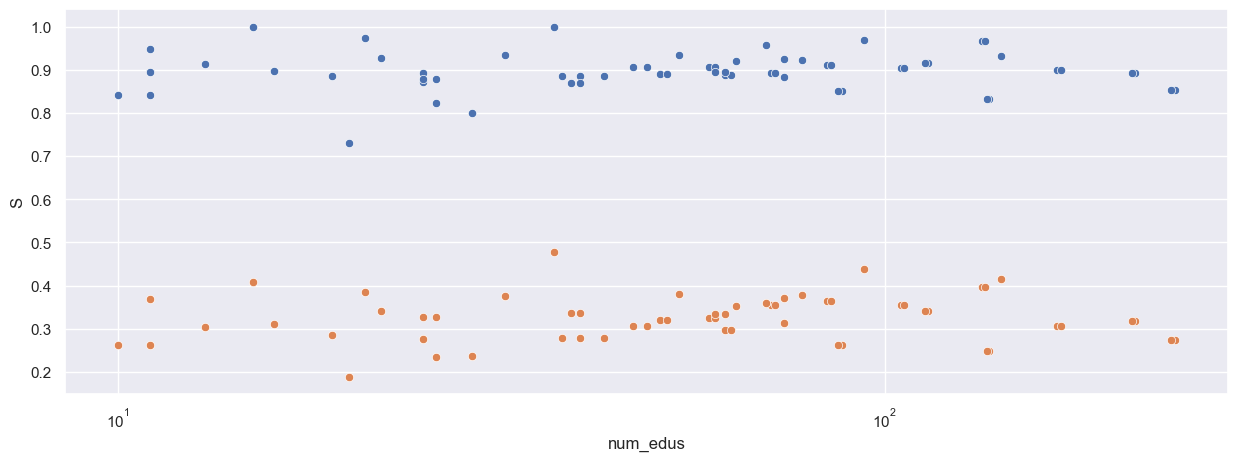

In [4]:
sns.set(rc={'figure.figsize':(15,5)})
ax = sns.scatterplot(data=df, x='num_edus', y='S' )
sns.scatterplot(data=df, x='num_edus', y='N', ax=ax )
#sns.scatterplot(data=df, x='num_edus', y='S', ax=ax )
#sns.scatterplot(data=df, x='num_edus', y='F', ax=ax )
plt.xscale('log')

# Question: Is jitter ok if the axis is in log scale??

# Span agreement

In [5]:
span_list = []
# List of dictionaries of the format {identifier: span: avg_depth: avg_height: status:}

for pair in annotation_pairs:
  main_spans = pair.gold_span_map
  for span, details in pair.gold_span_map.items():
    if type(details) == tuple:
      assert details[0] in ['Leaf', 'SegDiff']
      continue
    span_list.append({
        'identifier': pair.identifier,
        'span': span,
        'status': 1 if span in pair.predicted_span_map else 0, 
        'dummy':1,
        'total_edus': num_edus,
         'level': details['level'],
    })
    
df = pd.DataFrame.from_dict(span_list)



In [6]:
print(df.groupby(['level'])['status'].mean())
print(df.groupby(['level'])['status'].count())
print(df['status'].mean())


level
inter_para    0.560311
intra_para    0.740234
intra_sent    0.924787
Name: status, dtype: float64
level
inter_para    1285
intra_para    1024
intra_sent    3058
Name: status, dtype: int64
0.8023104155021428


# Nuclearity agreement

In [7]:
span_list = []
# List of dictionaries of the format {identifier: span: avg_depth: avg_height: status:}

for pair in annotation_pairs:
  main_spans = pair.gold_span_map
  for span, details in pair.gold_span_map.items():
    if type(details) == tuple:
      assert details[0] in ['Leaf', 'SegDiff']
      continue
    predicted_details = pair.predicted_span_map.get(span, None)
    if predicted_details is None or type(predicted_details) == tuple:
      continue
    span_list.append({
        'identifier': pair.identifier,
        'span': span,
        'status': 1 if details['nuclearity'] == predicted_details['nuclearity'] else 0, 
        'dummy':1,
        'total_edus': num_edus,
        'level': details['level'],
        'nuclearities': (details['nuclearity'], predicted_details['nuclearity']),
    })
    
    
df = pd.DataFrame.from_dict(span_list)



In [8]:
df.groupby('level')['nuclearities'].value_counts()

level       nuclearities
inter_para  (NS, NS)         336
            (NN, NN)         224
            (NN, NS)          48
            (NS, NN)          48
            (NS, SN)          20
            (SN, NS)          20
            (SN, SN)          12
            (NN, SN)           6
            (SN, NN)           6
intra_para  (NS, NS)         388
            (NN, NN)          90
            (NN, NS)          68
            (NS, NN)          68
            (SN, SN)          54
            (SN, NS)          29
            (NS, SN)          29
            (SN, NN)          16
            (NN, SN)          16
intra_sent  (NS, NS)        1504
            (NN, NN)         518
            (SN, SN)         506
            (NN, NS)          56
            (NS, NN)          56
            (NS, SN)          44
            (SN, NS)          44
            (SN, NN)          33
            (NN, SN)          33
Name: count, dtype: int64

In [9]:
print(df['status'].mean())
print(df.groupby('level')['status'].mean())

0.850187265917603
level
inter_para    0.794444
intra_para    0.701847
intra_sent    0.904796
Name: status, dtype: float64


# Relation agreement

In [13]:
span_list = []
# List of dictionaries of the format {identifier: span: avg_depth: avg_height: status:}

for pair in annotation_pairs:
  main_spans = pair.gold_span_map
  for span, details in pair.gold_span_map.items():
    if type(details) == tuple:
      assert details[0] in ['Leaf', 'SegDiff']
      continue
    predicted_details = pair.predicted_span_map.get(span, None)
    if predicted_details is None or type(predicted_details) == tuple:
      continue
    span_list.append({
        'identifier': pair.identifier,
        'span': span,
        'status': 1 if details['relation'] == predicted_details['relation'] else 0, 
        'dummy':1,
        'total_edus': num_edus,
        'level': details['level'],
        'relations': (details['relation'], predicted_details['relation']),
    })
    
    
df = pd.DataFrame.from_dict(span_list)
df.groupby('level')['status'].mean()


level
inter_para    0.586111
intra_para    0.519789
intra_sent    0.821045
Name: status, dtype: float64

In [12]:
df['relations'].value_counts()

relations
(elaboration, elaboration)      1166
(attribution, attribution)       662
(structure, structure)           326
(joint, joint)                   254
(contrast, contrast)             128
                                ... 
(enablement, attribution)          1
(attribution, topic-comment)       1
(attribution, enablement)          1
(topic-comment, attribution)       1
(attribution, temporal)            1
Name: count, Length: 197, dtype: int64